In [84]:
import sqlite3
import pandas as pd
import json

# Connexion à la première base de données
conn = sqlite3.connect('database.db')
# Lire la table depuis cette base de données et l'afficher
df = pd.read_sql_query("SELECT * from participant", conn)[['matchId', 'teamId', 'win', 'championName']]

# Fermer la connexion à la première base de données
conn.close()
df



,matchId,teamId,win,championName
0,EUW1_6648462202,100,0,Malphite
1,EUW1_6648462202,100,0,Kindred
2,EUW1_6648462202,100,0,Tristana
3,EUW1_6648462202,100,0,Seraphine
4,EUW1_6648462202,100,0,Rell
...,...,...,...,...
13505,EUW1_6645511796,200,1,Teemo
13506,EUW1_6645511796,200,1,Lillia
13507,EUW1_6645511796,200,1,Renekton
13508,EUW1_6645511796,200,1,Kaisa


In [85]:

champion_list = list(pd.read_json('champion.json').index)
champion_list = [i.lower() for i in champion_list] 



grouped = df.sort_values('teamId').groupby('matchId')
dataset = pd.DataFrame(columns=['matchId', 'champions', 'win'])
for id, group in grouped:
    
    champion_encoded_blue = [0]*len(champion_list)
    for champ in group['championName'].iloc[:5]:
        champion_encoded_blue[champion_list.index(champ.lower())] = 1

    champion_encoded_red = [0]*len(champion_list)
    for champ in group['championName'].iloc[5:10]:
        champion_encoded_red[champion_list.index(champ.lower())] = 1

    champion_encoded = champion_encoded_blue + champion_encoded_red
    new_line = pd.DataFrame([[group['matchId'].iloc[0], champion_encoded, group['win'].iloc[0]]], columns=['matchId', 'champions', 'win'])
    dataset = pd.concat([dataset, new_line], ignore_index=True)
    
dataset

,matchId,champions,win
0,EUW1_6615291154,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,EUW1_6615441057,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,EUW1_6619224580,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,EUW1_6619293216,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,EUW1_6619310994,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
...,...,...,...
1346,EUW1_6649816402,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1347,EUW1_6649825403,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1348,EUW1_6649843032,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1349,EUW1_6649843858,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


In [104]:
from sklearn import svm
from sklearn.model_selection import train_test_split

df_train, df_test  = train_test_split(dataset, test_size=0.2, random_state=0)

y_train = list(df_train["win"])
y_test = list(df_test["win"])

X_train = list(df_train["champions"])
X_test = list(df_test["champions"])

model = svm.SVC()
model.fit(X_train, y_train)



SVC()

In [105]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0])

Precision des prédiction :  0.5350553505535055


Matrice de confusion : 
[[94 49]
 [77 51]]
[[0.55 0.49]
 [0.45 0.51]]


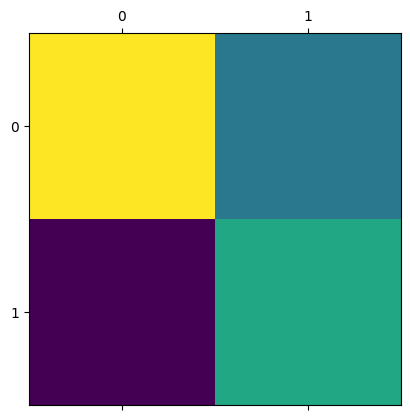

In [110]:
from sklearn.metrics import confusion_matrix
import numpy as np

def accuracy(pred,real):
    """Calule la précision des prédictions pred par rapport à real """
    count = 0
    L = len(pred)
    for i in range(L):
        if pred[i] == real[i]:
            count += 1
    return count/L



          
print("Precision des prédiction : ", accuracy(y_pred,np.array(y_test)))
print("\n\nMatrice de confusion : ")
print(confusion_matrix(y_test, y_pred).round(2))
print(confusion_matrix(y_test, y_pred, normalize = 'pred' ).round(2))



import matplotlib.pyplot as plt

plt.matshow(confusion_matrix(y_test, y_pred, normalize = 'pred' ))

